## Validate CA3 projections in CA1 microcircuit

In [1]:
import matplotlib.pyplot as plt

# package to work with the circuit
from bluepysnap import Circuit

In [2]:
circuit_path = '/home/data-bbp/20191017/circuit/sonata/circuit_config.json'

circuit = Circuit(circuit_path, node_population='All') # circuit object

In [3]:
proj = circuit.projection('SC')

AttributeError: 'Circuit' object has no attribute 'projection'

### Number of synapse per connection

In [ ]:
pre = circuit.cells.ids('CA3_PC')
post = circuit.cells.ids('Mosaic')
data = np.array([p[2] for p in proj.iter_connections(pre, post, return_synapse_count=True)])

In [ ]:
# plot
fig, ax = plt.subplots()

data = np.array(data)
nsyns = np.unique(data)

ax.hist(data, bins=np.append(nsyns, nsyns[-1]+1)-0.5)
# ax.set_xticks(nsyns)

_, y1 = ax.get_ylim()
mean = data.mean()
std = data.std()
ax.errorbar(mean, y1*0.9, xerr=std, color='k', fmt='o')

ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
ax.set_title('Number of SC synapses per connection', fontsize=20, y=1.08)
ax.set_xlabel('Number of synapses')
ax.set_ylabel('Number of connections')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.show()

### Distribution across layers

In [30]:
id_layer_map = {}
for column in hierarchy["children"]:
    for region in column["children"]:
        id_ = region["id"]
        layer = region["acronym"].split(";")[-1]
        id_layer_map[id_] = layer
id_layer_map[0] = 'out'

In [39]:
spacing = br_metadata["space directions"].diagonal()
offset = br_metadata["space origin"]
positions = syns.loc[:, ['x', 'y', 'z']].to_numpy()
indices = np.array((positions - offset) / spacing, dtype=int)
labels = br_data[tuple(indices.T)]
def _apply_mapping(x):
    return id_layer_map[x]

apply_mapping = np.vectorize(_apply_mapping)
layers = apply_mapping(labels)
syns['layer'] = layers

In [32]:
syns.head()

,offset,x,y,z,section_id,segment_id,tgid,sgid_path_distance,sgid,layer
0,0.619206,866.949678,420.800488,961.502316,158,23,1966,1.813566,0,SR
1,5.004660,821.907294,188.902518,428.473130,109,12,9311,10.821948,0,SP
2,0.102776,541.799133,405.830667,507.966888,160,53,3264,0.723073,0,SR
3,0.307752,207.664854,326.225937,975.833187,156,29,16251,1.282181,0,SR
4,1.115617,380.937872,330.437651,316.913136,131,0,9429,1.681385,0,SR


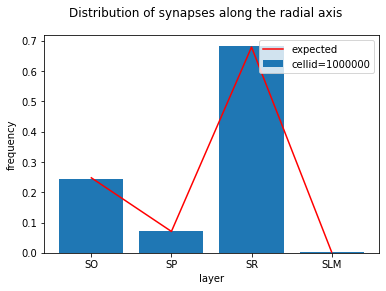

In [40]:
# model distribution
layers = ['SO', 'SP', 'SR', 'SLM']
mod_y_distr = np.array([np.count_nonzero(syns.layer==layer) for layer in layers], dtype=np.float32)
mod_y_distr = mod_y_distr/mod_y_distr.sum()
exp_y_distr = [0.2476014415, 0.0705293209, 0.6792951748, 0.0025740628]
x = np.arange(4)
fig, ax = plt.subplots()
ax.bar(x, mod_y_distr, label='cellid='+str(pregid))
ax.plot(x,exp_y_distr,color='r', label='expected')
plt.xticks(x, layers)
fig.suptitle('Distribution of synapses along the radial axis')
ax.set_xlabel('layer')
ax.set_ylabel('frequency')
plt.legend(loc='upper right')
timestamp = datetime.now().strftime('%Y%m%dT%H%M%S')
# plt.savefig('/home/romani/Desktop/radial_distr_'+timestamp+'.png')
plt.show()

### Distribution over XZ plane

Verify that the synapses are distributed uniformly in the XZ plane

In [36]:
!pip install -q feather-format

[]

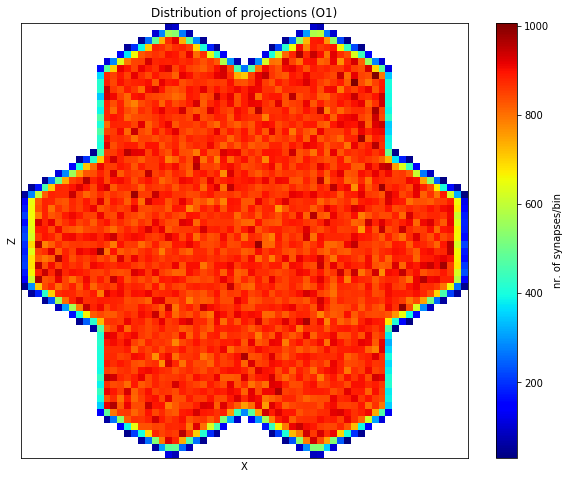

In [56]:
# read in synapse xyzs
import feather
# proj_path = "/gpfs/bbp.cscs.ch/project/proj42/circuits/O1/20181114/projection/synapses.feather"
syns = feather.read_dataframe(projection_path)  # workaround to read from feather format...
xyz = syns[["x", "y", "z"]]

# convert to density matrix
import numpy as np
def bin_space(x, y, x_min, x_max, y_min, y_max, bin_size):
    """"Bins the space for 'density plot'"""
    x_bins = np.arange(x_min, x_max, bin_size)
    y_bins = np.arange(y_min, y_max, bin_size)
    x_bins = np.append(x_bins, x_max)
    y_bins = np.append(y_bins, y_max)
    X = np.zeros((len(x_bins)-1, len(y_bins)-1))

    for i, (_x_min, _x_max) in enumerate(zip(x_bins[0:-1], x_bins[1:])):
        idx_x = np.where((_x_min < x) & (x <= _x_max))[0]
        for j, (_y_min, _y_max) in enumerate(zip(y_bins[0:-1], y_bins[1:])):
            idx_y = np.where((_y_min < y[idx_x]) & (y[idx_x] <= _y_max))[0]
            X[i, j] = len(idx_y)
        
    X[np.where(X == 0)] = np.nan
    return X

x_min = -260.0; x_max = 980.0
z_min = -20.0; z_max = 1280.0
bin_size = 20
dens_O1 = bin_space(xyz["x"].values, xyz["z"].values, x_min, x_max, z_min, z_max, bin_size)

# plt
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1)
i = ax.imshow(dens_O1, cmap="jet", aspect="auto", interpolation="nearest", origin="lower")
fig.colorbar(i, label="nr. of synapses/bin")
ax.set_title("Distribution of projections (O1)")
ax.set_xlabel("X"); ax.set_ylabel("Z")
ax.set_xticks([]); ax.set_yticks([])